In [1]:
import json
import os
import glob
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split

from pprint import pprint

import cv2
import matplotlib.pyplot as pt
from collections import defaultdict

In [2]:
imgsdir = Path("/Users/shreyas/Developer/Research/GroundingDINO/data/" \
    "satellite/images")
boxsdir = Path("/Users/shreyas/Developer/Research/GroundingDINO/dataset/resbox")

def get_images():
    for f in glob.glob(os.path.join(imgsdir, "*.tif")):
        yield os.path.basename(f).replace(".tif", "")

In [9]:
counts = defaultdict(list)

for f in get_images():
    counts["_".join(f.split("_")[:-1])].append(f)

for k, v in counts.items():
    print("{:>28}\t{}".format(k, len(v)))

            background_mango	488
        medium_density_mango	88
          background_coconut	241
          high_density_mango	90
           low_density_mango	78
         low_density_coconut	104
      medium_density_coconut	81
        high_density_coconut	94


In [10]:
counts["background"] = counts["background_mango"] + counts["background_coconut"]
del counts["background_coconut"]
del counts["background_mango"]

for k, v in counts.items():
    print("{:>28}\t{}".format(k, len(v)))

        medium_density_mango	88
          high_density_mango	90
           low_density_mango	78
         low_density_coconut	104
      medium_density_coconut	81
        high_density_coconut	94
                  background	729


In [11]:
# non existent boxes

for k, v in counts.items():
    if "background" in k:
        continue

    for e in v:
        if not os.path.exists(boxsdir / "{}.json".format(e)):
            print(e)
            continue

medium_density_mango_86
high_density_mango_56
high_density_mango_42
high_density_mango_22
high_density_mango_21
high_density_mango_10
high_density_mango_14
high_density_mango_28
high_density_mango_70
high_density_mango_65
high_density_mango_49
high_density_mango_74


In [20]:
extracts = {}

for k, v in counts.items():
    if k == "background":
        extracts[k] = np.random.choice(v, min(85, len(v)), replace=False)
    else:
        extracts[k] = np.random.choice(v, len(v), replace=False)

for k, v in extracts.items():
    print("{:>28}\t{}".format(k, len(v)))

print("sum:", sum(map(len, extracts.values())))

        medium_density_mango	88
          high_density_mango	90
           low_density_mango	78
         low_density_coconut	104
      medium_density_coconut	81
        high_density_coconut	94
                  background	85
sum: 620


In [21]:
s_images = [
    e.item()
    for v in extracts.values()
    for e in v
]

len(s_images)

620

In [22]:
categories = [
    {"id": 1, "name": "coconut"},
    {"id": 2, "name": "mango"},
]

In [14]:
def coco_boxes(category_id, image_id):
    try:
        # dt = json.load(open(f"/Users/shreyas/Developer/Research/GroundingDINO/data/satellite/boxes/{image_id}.json"))
        dt = json.load(open(f"/Users/shreyas/Developer/Research/GroundingDINO/dataset/resbox/{image_id}.json"))

    except FileNotFoundError as e:
        return []

    for box in dt:#["box"]:
        x1, y1, x2, y2 = box
        x, y, w, h = x1, y1, x2 - x1, y2 - y1

        box = [x, y, w, h]

        segmentation = [
            x+w, y+h,
            x+w, y,
            x, y,
            x, y+h,
        ]

        yield {
            "iscrowd": 0,
            "category_id": category_id, # 1 if "coconut" in image_id else 2,
            "bbox": [*map(float, box)],
            "segmentation": segmentation,
            "area": float(box[2] * box[3]),
        }

iid = "medium_density_mango_85"
next(coco_boxes(2 if "mango" in iid else 1, iid))

{'iscrowd': 0,
 'category_id': 2,
 'bbox': [31.0, 83.0, 21.0, 19.0],
 'segmentation': [52, 102, 52, 83, 31, 83, 31, 102],
 'area': 399.0}

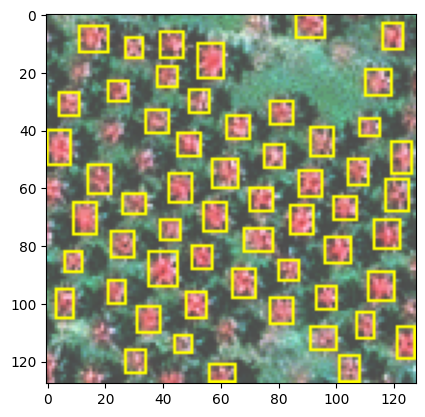

In [15]:
iid = "medium_density_coconut_4"

simg = cv2.imread(imgsdir / f"{iid}.tif")
cv2.cvtColor(simg, cv2.COLOR_BGR2RGB, simg)

for box in coco_boxes(2 if "mango" in iid else 1, iid):
# for box in dt["box"]:
#     x1, y1, x2, y2 = box
#     x, y, w, h = x1, y1, x2 - x1, y2 - y1

    x, y, w, h = map(int, box["bbox"])
    box = x, y, x+w, y+h
    # box = [int(128 - x) for x in box]
    # box = [box[1], box[0], box[3], box[2]]

    cv2.rectangle(simg, box[:2], box[2:], (255, 255, 0), 1)

pt.imshow(simg);

In [16]:
def ofmnm(s_images):
    images = []
    annotations = []

    category_id = 1

    for image_id, iname in enumerate(s_images, start=1):
        images.append({
            "file_name": f"{iname}.tif",
            "height": 128,
            "width": 128,
            "id": image_id,
        })

        c = category_id

        for at in coco_boxes(2 if "mango" in iname else 1, iname):
            at.update({
                "id": category_id,
                "image_id": image_id
            })

            annotations.append(at)
            category_id += 1

        if c == category_id and "background" not in iname:
            print("deleting", iname)
            del images[-1]

    return {
        "images": images,
        "annotations": annotations,
        "categories": categories }


In [17]:
np.random.shuffle(s_images)

In [31]:
train, test = train_test_split(s_images, test_size=0.15)
train, validation = train_test_split(train, test_size=0.15)

json.dump(ofmnm(s_images), open("coco/annotations.json", "w"), indent=2)
json.dump(ofmnm(train), open("coco/train.json", "w"), indent=2)
json.dump(ofmnm(validation), open("coco/validation.json", "w"), indent=2)
json.dump(ofmnm(test), open("coco/test.json", "w"), indent=2)

pprint({
    "train": len(train),
    "validation": len(validation),
    "test": len(test),
})

deleting high_density_mango_42
deleting high_density_mango_70
deleting high_density_mango_14
deleting high_density_mango_10
deleting high_density_mango_65
deleting high_density_mango_74
deleting high_density_mango_21
deleting high_density_mango_56
deleting high_density_mango_28
deleting high_density_mango_49
deleting medium_density_mango_86
deleting high_density_mango_22
deleting high_density_mango_49
deleting high_density_mango_22
deleting medium_density_mango_86
deleting high_density_mango_14
deleting high_density_mango_56
deleting high_density_mango_65
deleting high_density_mango_42
deleting high_density_mango_28
deleting high_density_mango_70
deleting high_density_mango_74
deleting high_density_mango_21
deleting high_density_mango_10
{'test': 85, 'train': 405, 'validation': 72}
